## Contents:
- [Import Libraries & Datasets](#Import-Libraries-&-Datasets)
- [Preprocessing and Feature Selection](#Preprocessing-and-Feature-Selection)
- [Apply Changes to Test Data](#Apply-Changes-to-Test-Data)

## Import Libraries & Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error

%matplotlib inline

#pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)

sample = pd.read_csv('./datasets/sample_sub_reg.csv')
test = pd.read_csv('./datasets/clean_test.csv')
train = pd.read_csv('./datasets/clean_train.csv')

## Preprocessing and Feature Selection

As there are currently 82 features in our dataset, it is desirable to reduce the number of input variables to reduce the computational cost, and also improves the model as too many variables can result in overfitting. 

As such, we'll use [filter feature selection methods](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/) to evaluate the relationship between each input variable and the target variable (Sale Price), and these scores are used as the basis to choose (filter) those input variables that will be used in the model.

All preprocessing and feature engineering will also apply to the test data



In [2]:
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,0.0,13517,Pave,NA_,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NA_,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NA_,NA_,NA_,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA_,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NA_,NA_,NA_,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA_,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NA_,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NA_,NA_,NA_,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA_,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NA_,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NA_,NA_,NA_,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA_,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NA_,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NA_,NA_,NA_,0,3,2010,WD,138500


### Features represented by Years (Discrete variables)

Exploring the features represented by years to see if we can combine them to have a greater impact to our model. First would like to check if there is any collinearity between the features by seeing their pearson coefficient, and also doing a pairwise plot to make some observations

                year_built  year_remod/add  garage_yr_blt   yr_sold  saleprice
year_built        1.000000        0.630181       0.845527 -0.003923   0.572256
year_remod/add    0.630181        1.000000       0.644079  0.043077   0.550055
garage_yr_blt     0.845527        0.644079       1.000000 -0.009968   0.550394
yr_sold          -0.003923        0.043077      -0.009968  1.000000  -0.015330
saleprice         0.572256        0.550055       0.550394 -0.015330   1.000000


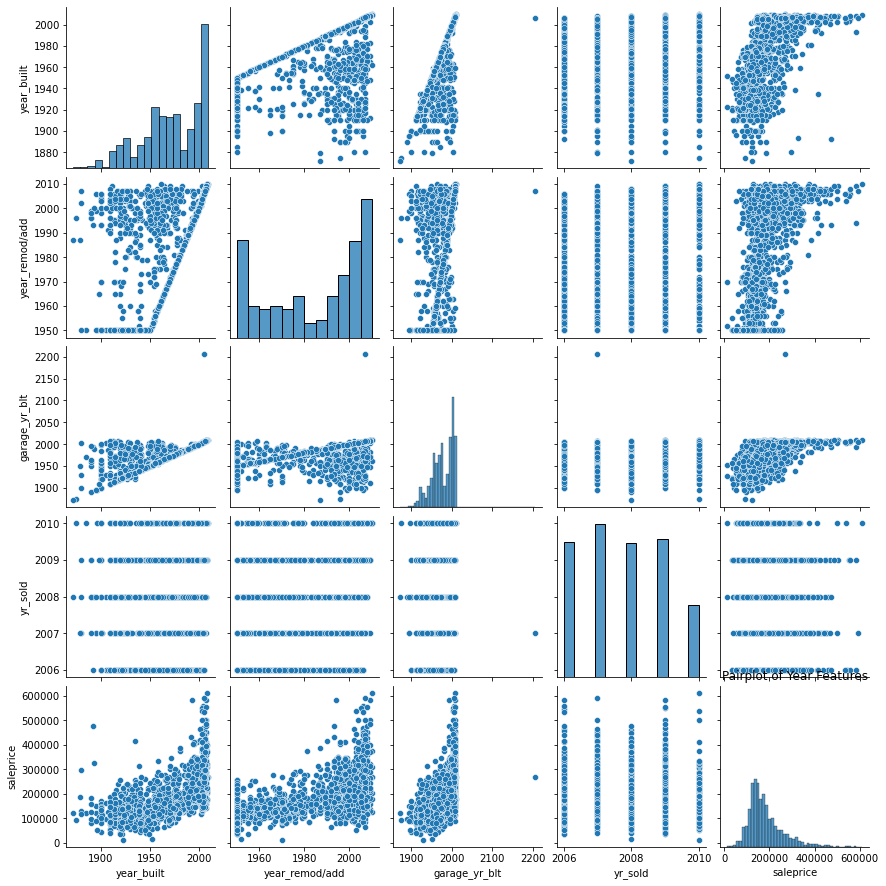

In [3]:
# Create dataframe containing all features that contain 'yr' & 'year'
df = train.loc[
    :,
    train.columns.str.contains('yr|year|saleprice') 
]

# See how they are correlated to each other
print(df.corr())

sns.pairplot(data=df)
plt.title('Pairplot of Year Features');

* There is no collinearity between the 'yr_sold' & 'year_built'. This is expected as we have only collected data for 'yr_sold' from 2006 - 2010, if there were any relationship to be observed, we will need to collect a bigger range.
    * However, we can combine these features to get the age of the house, which will prove to be a useful discrete variable to our model.
* There is a high correlation between 'yr_built','year_remod/add' & 'garage_yr_blt'. Looking at the pairplots, we can observe a linear relationship exist. 
    * This is also explained by the garage being built when the house is built. 
    * Also, where there is no remodelling done, the 'Year Remod/Add' will be same as the construction date as [describe](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).
    
With these observations, a new 'age' feature will be created based on year_built as its highly correlated with saleprice, and all other year features will be dropped

In [4]:
# Create new 'age' feature and include to training and test set
train['age'] = train['yr_sold'] - train['year_built']

# Drop 'year_remod/add'/'garage_yr_blt'/'yr_sold'
train = train.drop(columns=['year_remod/add','garage_yr_blt','yr_sold','year_built'])


### Features of additional observation identifiers (Discrete Variable)

These are the 2 features 'id' & 'pid' that are used in conjunction with the [Assessor's Office](http://www.cityofames.org/assessor/) or [Beacon](http://beacon.schneidercorp.com/) websites to directly view the records of a particular observation. They will not be valuable in our model and we'll drop them.

In [5]:
# Drop the features 'id' & 'pid'

train.drop(columns=['id','pid'], axis=1, inplace=True)

### Basement Features (Continuous Variables)

Would like to observe the bsmt features that are continuous variables to see if there is any collinearity and if we can combine them together. 

                bsmtfin_sf_1  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  \
bsmtfin_sf_1        1.000000     -0.050367    -0.474361       0.538830   
bsmtfin_sf_2       -0.050367      1.000000    -0.231714       0.086272   
bsmt_unf_sf        -0.474361     -0.231714     1.000000       0.418433   
total_bsmt_sf       0.538830      0.086272     0.418433       1.000000   
bsmt_full_bath      0.645637      0.156921    -0.403412       0.321263   
bsmt_half_bath      0.077531      0.093876    -0.109811       0.005349   
saleprice           0.424463      0.016393     0.191090       0.631507   

                bsmt_full_bath  bsmt_half_bath  saleprice  
bsmtfin_sf_1          0.645637        0.077531   0.424463  
bsmtfin_sf_2          0.156921        0.093876   0.016393  
bsmt_unf_sf          -0.403412       -0.109811   0.191090  
total_bsmt_sf         0.321263        0.005349   0.631507  
bsmt_full_bath        1.000000       -0.147021   0.283564  
bsmt_half_bath       -0.147021        1.000000 

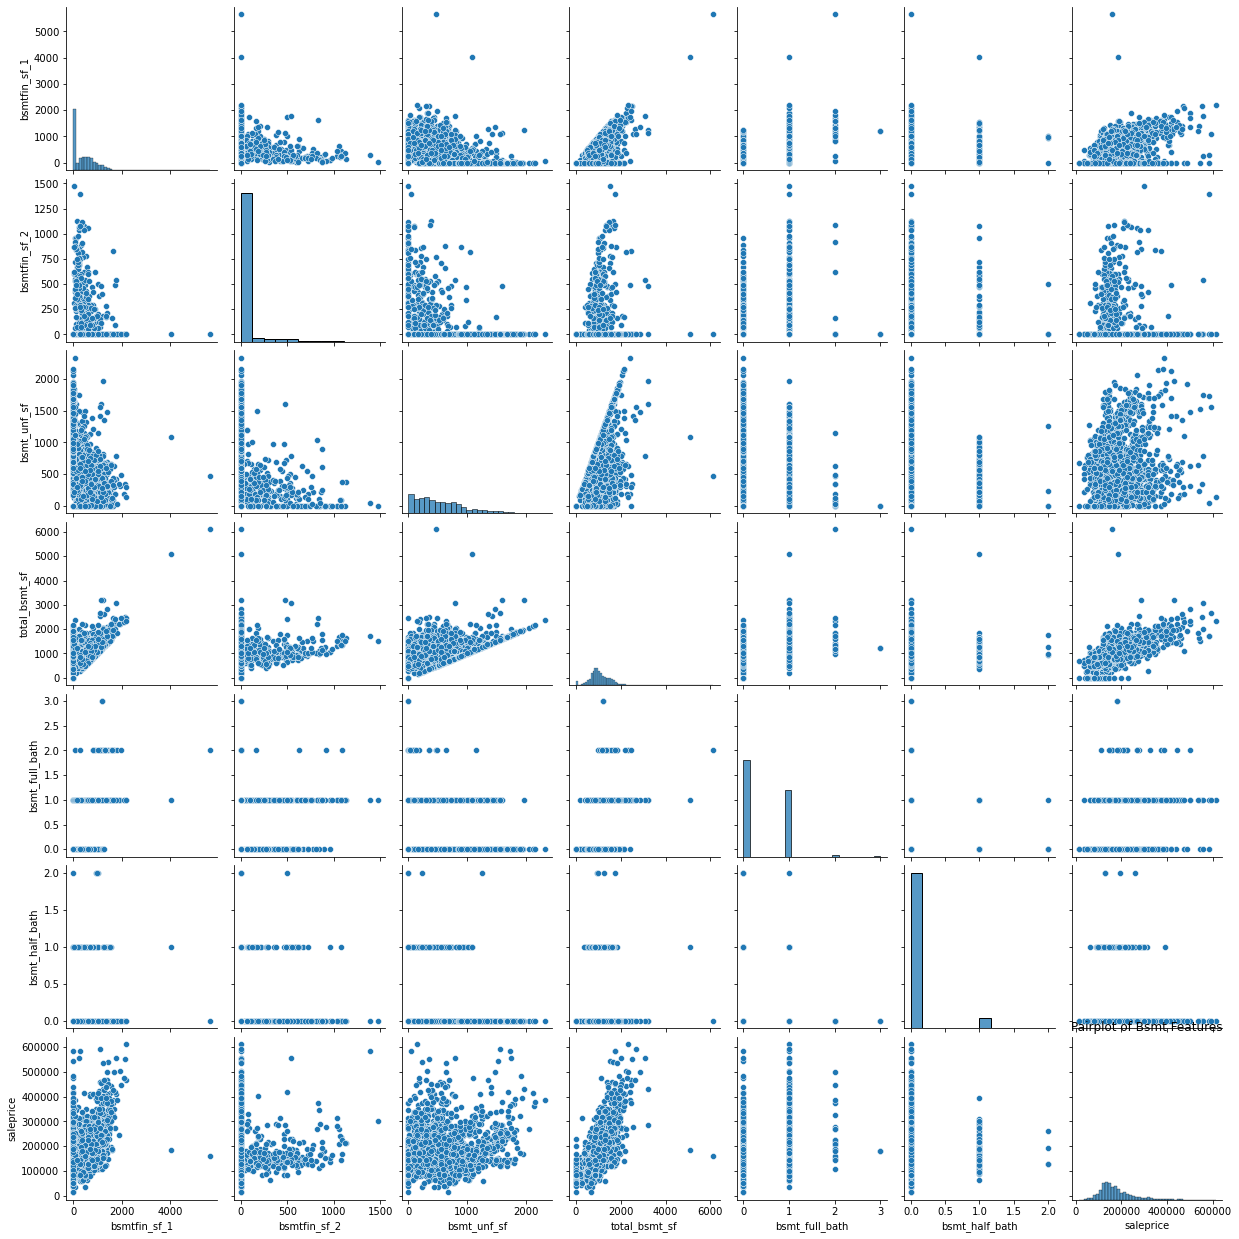

In [6]:
# Create dataframe containing all features that contain 'bsmt' & 'saleprice'
df = train.loc[
    :,
    train.columns.str.contains('bsmt|saleprice')
]

# See how they are correlated to each other
print(df.corr())

sns.pairplot(data=df)
plt.title('Pairplot of Bsmt Features');

* The pairplot shows that the 'total_bsmt_sf' has a linear relationship with 'bsmtfin_sf_1', 'bsmt_full_bath', 'bsmt_unf_sf'. 
* 'total_bsmt_sf' also has a strong linear relationship with the 'saleprice'
* I have chosen to drop all features except for 'total_bsmt_sf'

In [7]:
# Drop the features 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'bsmt_full_bath'
# 'bsmt_half_bath'

train.drop(
    columns=[
        'bsmtfin_sf_1', 
        'bsmtfin_sf_2', 
        'bsmt_unf_sf', 
        'bsmt_full_bath',
        'bsmt_half_bath'
    ], 
    axis=1, 
    inplace=True
)

### Ordinal Features

We want to observe the ordinal variables and drop them if necessary. At the same time, we will map them according to their ordered categories.

In [8]:
# Check the value count
print(train['lot_shape'].value_counts())

# Map the numerical value according to irregularities
train['lot_shape'] = train['lot_shape'].map({
    'Reg':0,
    'IR1':1,
    'IR2':2,
    'IR3':3
})

Reg    1294
IR1     690
IR2      55
IR3       9
Name: lot_shape, dtype: int64


In [9]:
# Check the value count
print(train['utilities'].value_counts(normalize=True))

# As there are only 2 values that are not 'AllPub', we will drop this feature as its not useful for our model
train.drop(columns='utilities', axis=1, inplace=True)

AllPub    0.999023
NoSewr    0.000488
NoSeWa    0.000488
Name: utilities, dtype: float64


In [10]:
# Check the value count
print(train['land_slope'].value_counts(normalize=True))

# As 95% of the values are a gentleslope, we will drop this feature as its not useful for our model
train.drop(columns='land_slope', axis=1, inplace=True)

Gtl    0.952148
Mod    0.042969
Sev    0.004883
Name: land_slope, dtype: float64


In [11]:
# Check the value count
print(train['overall_qual'].value_counts())
print(train['overall_cond'].value_counts())

5     561
6     506
7     431
8     250
4     158
9      77
3      29
10     23
2       9
1       4
Name: overall_qual, dtype: int64
5    1168
6     367
7     268
8     101
4      70
3      35
9      29
2       6
1       4
Name: overall_cond, dtype: int64


We won't need to map any values for 'overall_qual' & 'overall_cond' as they are represented in order by integers

In [12]:
# Check the value Count
print(train['exter_qual'].value_counts())
print(train['exter_cond'].value_counts())

TA    1244
Gd     697
Ex      81
Fa      26
Name: exter_qual, dtype: int64
TA    1775
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64


In [13]:
# We will map the variables accordingly to the scale
train['exter_qual'] = train['exter_qual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3, 'Ex':4})
train['exter_cond'] = train['exter_cond'].map({'Po':0,'Fa':1,'TA':2,'Gd':3, 'Ex':4})

In [14]:
# Check the value Count
print(train['bsmt_qual'].value_counts())
print(train['bsmt_cond'].value_counts())

# We will map the variables accordingly to the scale
train['bsmt_qual'] = train['bsmt_qual'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4, 'Ex':5})
train['bsmt_cond'] = train['bsmt_cond'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4, 'Ex':5})

TA     887
Gd     863
Ex     184
Fa      60
NA_     53
Po       1
Name: bsmt_qual, dtype: int64
TA     1833
Gd       89
Fa       65
NA_      53
Po        5
Ex        3
Name: bsmt_cond, dtype: int64


In [15]:
# Check the value Count
print(train['bsmt_exposure'].value_counts())

# We will map the variables accordingly to the scale
train['bsmt_exposure'] = train['bsmt_exposure'].map({'NA_':0,'No':1,'Mn':2,'Av':3,'Gd':4})

No     1338
Av      288
Gd      203
Mn      163
NA_      56
Name: bsmt_exposure, dtype: int64


In [16]:
# Check the value Count
print(train['bsmtfin_type_1'].value_counts())
print(train['bsmtfin_type_2'].value_counts())

# We will map the variables accordingly to the scale
train['bsmtfin_type_1'] = train['bsmtfin_type_1'].map({'NA_':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
train['bsmtfin_type_2'] = train['bsmtfin_type_2'].map({'NA_':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})

GLQ    615
Unf    603
ALQ    292
BLQ    200
Rec    183
LwQ    102
NA_     53
Name: bsmtfin_type_1, dtype: int64
Unf    1748
Rec      80
LwQ      60
NA_      54
BLQ      48
ALQ      35
GLQ      23
Name: bsmtfin_type_2, dtype: int64


In [17]:
# Check the value Count
print(train['heating_qc'].value_counts())

# We will map the variables accordingly to the scale
train['heating_qc'] = train['heating_qc'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

Ex    1064
TA     595
Gd     319
Fa      67
Po       3
Name: heating_qc, dtype: int64


In [18]:
# Check the value Count
print(train['central_air'].value_counts(normalize=True))

# As only 6.8% is no, we will drop this feature as its not useful for our model
train.drop(columns='central_air', axis=1, inplace=True)

Y    0.931152
N    0.068848
Name: central_air, dtype: float64


In [19]:
# Check the value Count
print(train['electrical'].value_counts())

# We will map the variables accordingly to the scale
train['electrical'] = train['electrical'].map({'Mix':0,'FuseP':1,'FuseF':2,'FuseA':3,'SBrkr':4})

SBrkr    1866
FuseA     139
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64


In [20]:
# Check the value Count
print(train['kitchen_qual'].value_counts())

# We will map the variables accordingly to the scale
train['kitchen_qual'] = train['kitchen_qual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

TA    1046
Gd     805
Ex     150
Fa      47
Name: kitchen_qual, dtype: int64


In [21]:
# Check the value Count
print(train['functional'].value_counts())

# We will map the variables accordingly to the scale
train['functional'] = train['functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})

Typ     1912
Min1      42
Min2      42
Mod       29
Maj1      12
Maj2       7
Sal        2
Sev        2
Name: functional, dtype: int64


In [22]:
# Check the value Count
print(train['fireplace_qu'].value_counts())

# We will map the variables accordingly to the scale
train['fireplace_qu'] = train['fireplace_qu'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})


NA_    998
Gd     522
TA     407
Fa      59
Po      31
Ex      31
Name: fireplace_qu, dtype: int64


In [23]:
# Check the value Count
print(train['garage_finish'].value_counts())

# We will map the variables accordingly to the scale
train['garage_finish'] = train['garage_finish'].map({'NA_':0,'Unf':1,'RFn':2,'Fin':3})

Unf    847
RFn    579
Fin    509
NA_    113
Name: garage_finish, dtype: int64


In [24]:
# Check the value Count
print(train['garage_qual'].value_counts())
print(train['garage_cond'].value_counts())

# We will map the variables accordingly to the scale
train['garage_qual'] = train['garage_qual'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
train['garage_cond'] = train['garage_cond'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

TA     1830
NA_     113
Fa       82
Gd       18
Ex        3
Po        2
Name: garage_qual, dtype: int64
TA     1866
NA_     113
Fa       47
Gd       12
Po        8
Ex        2
Name: garage_cond, dtype: int64


In [25]:
# Check the value Count
print(train['paved_drive'].value_counts(normalize=True))

# We will drop this feature as its not useful for our model
train.drop(columns='paved_drive', axis=1, inplace=True)

Y    0.907227
N    0.073730
P    0.019043
Name: paved_drive, dtype: float64


In [26]:
# Check the value Count
print(train['pool_qc'].value_counts(normalize=True))

# We will drop this feature as its not useful for our model
train.drop(columns='pool_qc', axis=1, inplace=True)

NA_    0.995605
Gd     0.001953
Fa     0.000977
TA     0.000977
Ex     0.000488
Name: pool_qc, dtype: float64


In [27]:
# Check the value Count
print(train['fence'].value_counts(normalize=True))

# We will combine some categories together
train['fence'] = train['fence'].map({'NA_':0,'MnWw':1,'GdWo':1,'GdPrv':1,'MnPrv':1})

NA_      0.805664
MnPrv    0.109863
GdPrv    0.040527
GdWo     0.039062
MnWw     0.004883
Name: fence, dtype: float64


In [28]:
train.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,lot_config,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,total_bsmt_sf,heating,heating_qc,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,sale_type,saleprice,age
0,60,RL,0.0,13517,Pave,NA_,1,Lvl,CulDSac,Sawyer,RRAe,Norm,1Fam,2Story,6,8,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,3,2,CBlock,3,3,1,6,1,725.0,GasA,4,4,725,754,0,1479,2,1,3,1,3,6,7,0,0,Attchd,2,2.0,475.0,3,3,0,44,0,0,0,0,0,NA_,0,3,WD,130500,34
1,60,RL,43.0,11492,Pave,NA_,1,Lvl,CulDSac,SawyerW,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,3,2,PConc,4,3,1,6,1,913.0,GasA,4,4,913,1209,0,2122,2,1,4,1,3,8,7,1,3,Attchd,2,2.0,559.0,3,3,0,74,0,0,0,0,0,NA_,0,4,WD,220000,13
2,20,RL,68.0,7922,Pave,NA_,0,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,3,CBlock,3,3,1,6,1,1057.0,GasA,2,4,1057,0,0,1057,1,0,3,1,3,5,7,0,0,Detchd,1,1.0,246.0,3,3,0,52,0,0,0,0,0,NA_,0,1,WD,109000,57
3,60,RL,73.0,9802,Pave,NA_,0,Lvl,Inside,Timber,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,1,1,1,384.0,GasA,3,4,744,700,0,1444,2,1,3,1,2,7,7,0,0,BuiltIn,3,2.0,400.0,3,3,100,0,0,0,0,0,0,NA_,0,4,WD,174000,4
4,50,RL,82.0,14235,Pave,NA_,1,Lvl,Inside,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,Gable,CompShg,Wd Sdng,Plywood,None,0.0,2,2,PConc,2,4,1,1,1,676.0,GasA,2,4,831,614,0,1445,2,0,3,1,2,6,7,0,0,Detchd,1,2.0,484.0,3,3,0,59,0,0,0,0,0,NA_,0,3,WD,138500,110


### Continuous Features Correlation to SalePrice

We want to know which features correlate to our target feature 'saleprice', and choose the top 30 (both positively & negatively) correlated features for our model, based on pearson's coefficient. 

In [29]:
# Which features correlates to saleprice the most?

abs(train.corr(
).loc[
    :,
    'saleprice'
]).sort_values(ascending=False)



saleprice          1.000000
overall_qual       0.800975
exter_qual         0.712880
gr_liv_area        0.698046
kitchen_qual       0.692190
garage_area        0.650000
garage_cars        0.648103
total_bsmt_sf      0.631507
1st_flr_sf         0.621181
bsmt_qual          0.617419
age                0.572284
garage_finish      0.558638
fireplace_qu       0.538252
full_bath          0.537369
mas_vnr_area       0.504025
totrms_abvgrd      0.502909
fireplaces         0.470091
heating_qc         0.459327
bsmt_exposure      0.425634
bsmtfin_type_1     0.351319
open_porch_sf      0.332090
wood_deck_sf       0.327007
lot_area           0.295121
lot_shape          0.294852
garage_qual        0.285858
half_bath          0.282023
garage_cond        0.265517
2nd_flr_sf         0.249091
electrical         0.246841
bsmt_cond          0.228258
lot_frontage       0.181342
fence              0.180310
enclosed_porch     0.135516
bedroom_abvgr      0.135178
screen_porch       0.134652
functional         0

In [30]:
# drop the rows below 0.2
train.drop(
    columns = [
        'lot_frontage','fence','enclosed_porch','bedroom_abvgr','screen_porch','functional',
        'kitchen_abvgr','overall_cond','ms_subclass','3ssn_porch','low_qual_fin_sf','exter_cond',
        'mo_sold','pool_area','bsmtfin_type_2','misc_val'
    ],           
    axis=1, 
    inplace=True
)  

In [31]:
train.shape

(2048, 50)

We have reduced our features to 45. Based on reducing our parameters, the model should be more robust against overfitting, which would have introduced bias. 
On hindsight, this did not consider the interactions with other features which could be of significant correlation, and does not consider the model being employed.

### Nominal Features

### Nominal Features with 3 or less variable types

We would like to observe the categories for these first as they can tell us how much they are fairing

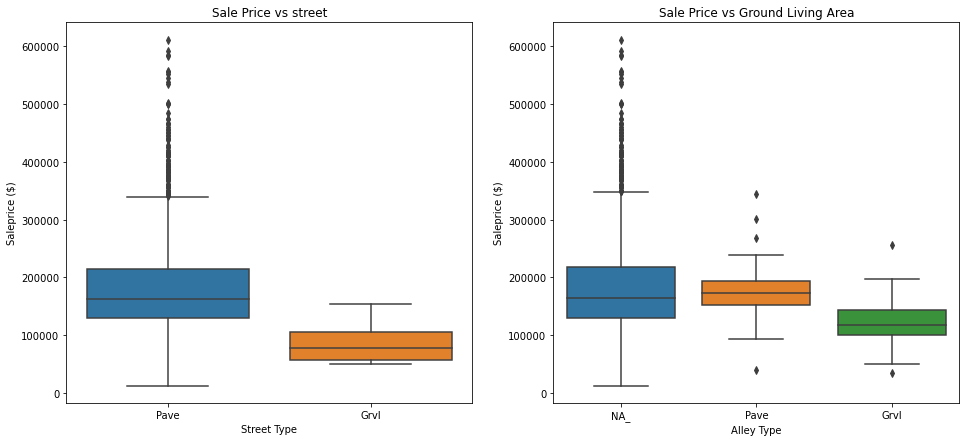

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 7))

sns.boxplot(ax=ax1, data=train, x='street', y='saleprice')
ax1.set_title('Sale Price vs street')
ax1.set_xlabel('Street Type')
ax1.set_ylabel('Saleprice ($)');

sns.boxplot(ax=ax2, data=train, x='alley', y='saleprice')
ax2.set_title('Sale Price vs Ground Living Area')
ax2.set_xlabel('Alley Type')
ax2.set_ylabel('Saleprice ($)');

In [33]:
# Check the value Count
print(train['street'].value_counts(normalize=True))

# Drop street feature
train.drop(columns='street', axis=1, inplace=True)

Pave    0.996582
Grvl    0.003418
Name: street, dtype: float64


* The boxplot shows a very clear distinction between the categories in relation to the sale price
* Furthermore, 99.6% of the data is the same value, hence there is little variation and the model will not learn much from this, hence we will drop this feature

In [34]:
# Check the value Count
print(train['alley'].value_counts(normalize=True))

# drop alley feature
train.drop(columns='alley', axis=1, inplace=True)

NA_     0.931641
Grvl    0.041504
Pave    0.026855
Name: alley, dtype: float64


* The boxplot shows that the median and mean for the 3 categories are very similar, hence there isn't much distinction in relation to saleprice.
* Furthermore, 93% of the data is the same value, hence there is little variation and the model will not learn much from this, hence we will drop this feature

### One Hot Encode the nominal variables

In [35]:
train.head()

,ms_zoning,lot_area,lot_shape,land_contour,lot_config,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,total_bsmt_sf,heating,heating_qc,electrical,1st_flr_sf,2nd_flr_sf,gr_liv_area,full_bath,half_bath,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,wood_deck_sf,open_porch_sf,misc_feature,sale_type,saleprice,age
0,RL,13517,1,Lvl,CulDSac,Sawyer,RRAe,Norm,1Fam,2Story,6,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,3,CBlock,3,3,1,6,725.0,GasA,4,4,725,754,1479,2,1,3,6,0,0,Attchd,2,2.0,475.0,3,3,0,44,NA_,WD,130500,34
1,RL,11492,1,Lvl,CulDSac,SawyerW,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,3,PConc,4,3,1,6,913.0,GasA,4,4,913,1209,2122,2,1,3,8,1,3,Attchd,2,2.0,559.0,3,3,0,74,NA_,WD,220000,13
2,RL,7922,0,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,CBlock,3,3,1,6,1057.0,GasA,2,4,1057,0,1057,1,0,3,5,0,0,Detchd,1,1.0,246.0,3,3,0,52,NA_,WD,109000,57
3,RL,9802,0,Lvl,Inside,Timber,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,PConc,4,3,1,1,384.0,GasA,3,4,744,700,1444,2,1,2,7,0,0,BuiltIn,3,2.0,400.0,3,3,100,0,NA_,WD,174000,4
4,RL,14235,1,Lvl,Inside,SawyerW,Norm,Norm,1Fam,1.5Fin,6,Gable,CompShg,Wd Sdng,Plywood,None,0.0,2,PConc,2,4,1,1,676.0,GasA,2,4,831,614,1445,2,0,2,6,0,0,Detchd,1,2.0,484.0,3,3,0,59,NA_,WD,138500,110


In [36]:
nominal_columns = [
    'ms_zoning',
    'land_contour',
    'lot_config',
    'neighborhood',
    'condition_1',
    'condition_2',
    'bldg_type',
    'house_style',
    'roof_style',
    'roof_matl',
    'exterior_1st',
    'exterior_2nd',
    'mas_vnr_type',
    'foundation',
    'heating',
    'garage_type',
    'misc_feature',
    'sale_type'
]

train = pd.get_dummies(
                data = train,
                columns = nominal_columns,
                )
train.shape

(2048, 184)

### Interaction Features

We want to observe if there are any interaction features we might want to add to our model. Lets

In [37]:
# Create 2 dataframes to represent the features and the target
X = train.drop(columns='saleprice')
y = train['saleprice']

# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)

# Fit & Transform the features on the order of 2
X_poly = poly.fit_transform(X)

# Create dataframe for polynomial features
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(X.columns))

# Display the top 10 features correlated with our target
abs(df_poly.corrwith(y).sort_values(ascending=False))[:10]

overall_qual gr_liv_area     0.836925
exter_qual gr_liv_area       0.827514
overall_qual^2               0.826386
overall_qual kitchen_qual    0.826095
gr_liv_area kitchen_qual     0.822594
overall_qual exter_qual      0.822327
overall_qual garage_cars     0.820607
bsmt_qual gr_liv_area        0.816782
overall_qual bsmt_qual       0.815040
overall_qual garage_area     0.813707
dtype: float64

It is observed that the top interaction feature is the 'overall_qual' & 'gr_liv_area' with 0.84. This was somewhat expected as we can see from our previous correlation table that 'overall_qual' is 0.80 and 'gr_liv_area' is 0.70. 

However, there isn't much improvement from their interaction, hence I will not be including any interaction features, as it could overfit the model.

In [38]:
train.shape

(2048, 184)

## Apply Changes to Test Data

In [39]:
#This code defines a function that can be edited as necessary, 
#that applies all data processing changes to new test data.

test['age'] = test['yr_sold'] - test['year_built']
test.drop(columns=['year_remod/add','garage_yr_blt','yr_sold','year_built'], axis=1, inplace=True)
test.drop(columns=['id','pid'], axis=1, inplace=True)
test.drop(columns=['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'bsmt_full_bath','bsmt_half_bath'], axis=1, inplace=True)
test['lot_shape'] = test['lot_shape'].map({'Reg':0,'IR1':1,'IR2':2,'IR3':3})
test.drop(columns='utilities', axis=1, inplace=True)
test.drop(columns='land_slope', axis=1, inplace=True)
test['exter_qual'] = test['exter_qual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3, 'Ex':4})
test['exter_cond'] = test['exter_cond'].map({'Po':0,'Fa':1,'TA':2,'Gd':3, 'Ex':4})
test['bsmt_qual'] = test['bsmt_qual'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4, 'Ex':5})
test['bsmt_cond'] = test['bsmt_cond'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4, 'Ex':5})
test['bsmt_exposure'] = test['bsmt_exposure'].map({'NA_':0,'No':1,'Mn':2,'Av':3,'Gd':4})
test['bsmtfin_type_1'] = test['bsmtfin_type_1'].map({'NA_':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
test['bsmtfin_type_2'] = test['bsmtfin_type_2'].map({'NA_':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})                                                     
test['heating_qc'] = test['heating_qc'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
test.drop(columns='central_air', axis=1, inplace=True)
test['electrical'] = test['electrical'].map({'Mix':0,'FuseP':1,'FuseF':2,'FuseA':3,'SBrkr':4})                                                  
test['kitchen_qual'] = test['kitchen_qual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
test['functional'] = test['functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})                                                     
test['fireplace_qu'] = test['fireplace_qu'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
test['garage_finish'] = test['garage_finish'].map({'NA_':0,'Unf':1,'RFn':2,'Fin':3})
test['garage_qual'] = test['garage_qual'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
test['garage_cond'] = test['garage_cond'].map({'NA_':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})                                     
test.drop(columns='paved_drive', axis=1, inplace=True)                                                    
test.drop(columns='pool_qc', axis=1, inplace=True)                                                   
test['fence'] = test['fence'].map({'NA_':0,'MnWw':1,'GdWo':1,'GdPrv':1,'MnPrv':1})                                                     
test.drop(columns='street', axis=1, inplace=True)                                                     
test.drop(columns='alley', axis=1, inplace=True)                                                    
test.drop( 
    columns = ['lot_frontage','fence','enclosed_porch','bedroom_abvgr','screen_porch','functional',
               'kitchen_abvgr','overall_cond','ms_subclass','3ssn_porch','low_qual_fin_sf','exter_cond',
               'mo_sold','pool_area','bsmtfin_type_2','misc_val'],           
    axis=1, 
    inplace=True
)  
nominal_columns = ['ms_zoning','land_contour','lot_config','neighborhood','condition_1',
                   'condition_2','bldg_type','house_style','roof_style','roof_matl','exterior_1st',
                   'exterior_2nd', 'mas_vnr_type','foundation','heating','garage_type','misc_feature','sale_type']
test = pd.get_dummies(data = test, columns = nominal_columns) 
        
    

In [40]:
# Columns that are in either test & train but not in their intersection
test.columns.symmetric_difference(train.columns)

Index(['condition_2_Artery', 'condition_2_RRAe', 'condition_2_RRAn',
       'condition_2_RRNn', 'exterior_1st_CBlock', 'exterior_1st_ImStucc',
       'exterior_1st_PreCast', 'exterior_1st_Stone', 'exterior_2nd_Other',
       'exterior_2nd_PreCast', 'exterior_2nd_Stone', 'heating_Floor',
       'heating_OthW', 'heating_Wall', 'mas_vnr_type_CBlock',
       'misc_feature_Elev', 'misc_feature_TenC', 'ms_zoning_A (agr)',
       'neighborhood_GrnHill', 'neighborhood_Landmrk', 'roof_matl_ClyTile',
       'roof_matl_Membran', 'roof_matl_Metal', 'roof_matl_Roll',
       'sale_type_VWD', 'saleprice'],
      dtype='object')

There are some categorical features in either of the test or train but not in both. This could be due to either not having the same type of variables in the categorical features. As our final model requires that the test and train data have the same features, we will drop the above features to synchronize

In [41]:
# List of test columns that are not in train columns
print(test.columns.difference(train.columns))

# Remove test columns that are not in train columns
test = test.drop(
    columns =[
       'exterior_1st_PreCast', 'exterior_2nd_Other', 'exterior_2nd_PreCast',
       'heating_Floor', 'mas_vnr_type_CBlock', 'roof_matl_Metal',
       'roof_matl_Roll', 'sale_type_VWD'
    ],   
    axis = 1
)

Index(['exterior_1st_PreCast', 'exterior_2nd_Other', 'exterior_2nd_PreCast',
       'heating_Floor', 'mas_vnr_type_CBlock', 'roof_matl_Metal',
       'roof_matl_Roll', 'sale_type_VWD'],
      dtype='object')


In [42]:
# List of train columns that are not in test columns
print(train.columns.difference(train.columns))

# Remove train columns that are not in test columns
train = train.drop(
    columns =[
       'condition_2_Artery', 'condition_2_RRAe', 'condition_2_RRAn', 
       'condition_2_RRNn', 'exterior_1st_CBlock',
       'exterior_1st_ImStucc', 'exterior_1st_Stone', 'exterior_2nd_Stone',
       'heating_OthW', 'heating_Wall', 'misc_feature_Elev',
       'misc_feature_TenC', 'ms_zoning_A (agr)', 'neighborhood_GrnHill',
       'neighborhood_Landmrk', 'roof_matl_ClyTile', 'roof_matl_Membran',
    ],
    axis = 1
)

Index([], dtype='object')


In [43]:
print(test.columns.symmetric_difference(train.columns))
print(test.shape)
print(train.shape)

Index(['saleprice'], dtype='object')
(879, 166)
(2048, 167)


### Export data to folder

In [44]:
# Write train & test dataframe to a csv file and store in folder
train.to_csv('./datasets/preprocess_train.csv', index=False)
test.to_csv('./datasets/preprocess_test.csv', index=False)